In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
from nanonets import Simulation
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

## DC Input - Voltage Distribution - Closed Circuit

In [511]:
def shift_and_append(dfs_dict):
    for name, df in dfs_dict.items():
        col1 = df.pop("1")  # remove column 1
        df.columns = range(df.shape[1])  # reassign column names to keep them sequential
        df[f"{len(df.columns)}"] = col1  # append column 1's data at the end
    return dfs_dict


# Parameter
folder      = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/293/"
N_voltages  = 50000
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]

# Potentials
U_0_vals    = [pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Ne=2.csv").loc[0,'E0'] for N_p in N_vals]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Ne=2.csv") for N_p in N_vals}
pot         = shift_and_append(pot)
pot_eq      = pd.DataFrame([pot[N_p].iloc[45000:,:].mean().values / U_0_vals[i] for i, N_p in enumerate(N_vals)],index=N_vals).T.round(2)

# Output Current
out_curr    = {N_p : pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Ne=2.csv")['Observable'].values for N_p in N_vals}

### Steady State

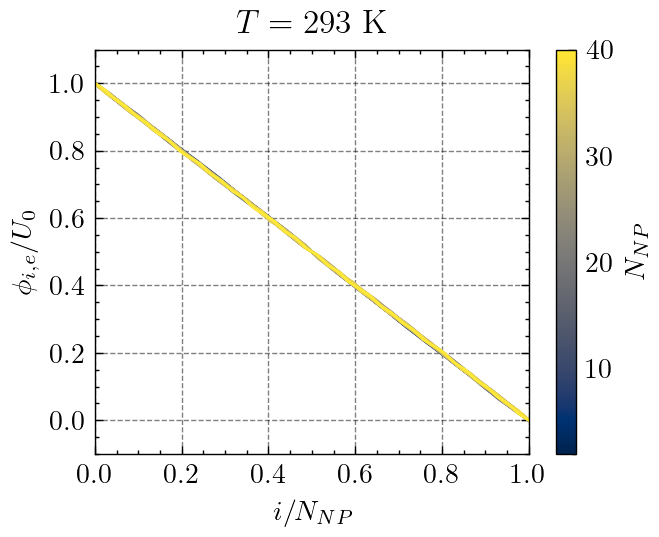

In [512]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_potential.svg", transparent=True)

- Potential decays linearly from $U_0$ to $0$ V, which confirms the **Ohmic response** of the string $$\phi_i = U_0 (1 - \frac{i}{N_{NP}})$$
- Equal potential difference $\Delta \phi = \frac{U_0}{N_{NP}}$ imply uniform **voltage drops** across each junction

### Characteristic Time Scale

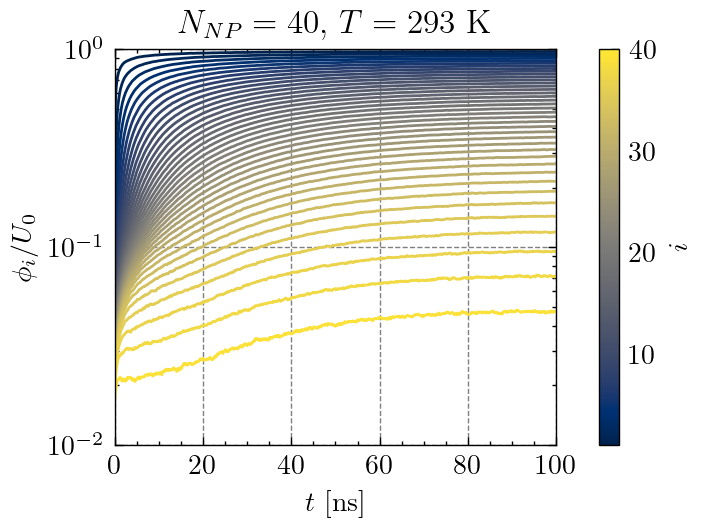

In [516]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
Np      = 40
i_U0    = np.where(np.array(N_vals)==Np)[0][0]
U_0     = U_0_vals[i_U0]
norm    = Normalize(vmin=1, vmax=Np)

for i in range(1,Np):
    ax.plot(t_vals, pot[Np][i].values/U_0, color=cm(norm(i)))

ax.set_title("$N_{NP} = 40$, $T = 293$ K")
ax.set_xlim(0,100)
ax.set_ylim(0.01,1)
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

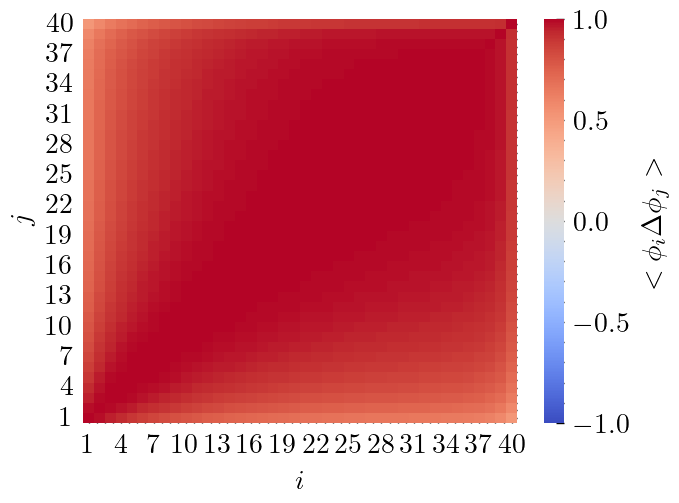

In [517]:
Np  = 40
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(pot[Np].iloc[:,1:-1].corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\phi_{i}\Delta\phi_{j}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$j$")
ax.invert_yaxis()
plt.yticks(rotation=0) 

fig.savefig("../plots/dc_input/linear/closed_circuit_node_pot_corr.svg", transparent=True)

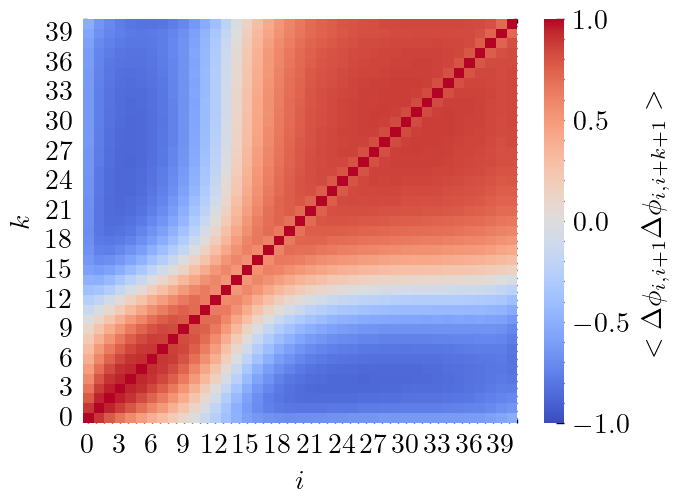

In [518]:
Np      = 40
p_diff  = pot[Np].diff(axis=1).drop(columns=0).values
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")
ax.invert_yaxis()
plt.yticks(rotation=0) 

fig.savefig("../plots/dc_input/linear/closed_circuit_node_pot_diff_corr.svg", transparent=True)

- Strong short range correlations: Diffusive charge spreading
- Long range anti-correlations: Charges at distant NPs adjust to maintain linear potential gradient globally

## Fitting the relaxation process

Fitting the slowest mode time constant using a simple exponential

In [405]:
p_vals, cov_vals = {}, {}
p0, p1 = 0.9, 0.995
for Np in N_vals:
    p_tmp, cov_tmp = [], []
    for k in range(1,Np+1):

        x       = t_vals.copy()
        y       = pot[Np].loc[:,k].values
        y_max   = np.mean(y[-1000:])
        def func(t, tau, a0):
            return y_max - a0*np.exp(-t/tau)
        
        t0      = np.argmax(y>p0*y_max)
        t1      = np.argmax(y>p1*y_max)
        x_fit   = x.copy()[t0:t1]
        y_fit   = y.copy()[t0:t1]
        p, cov  = curve_fit(func, x_fit, y_fit, p0=[20,y_max], bounds=((0,0),(np.inf,np.inf)))

        p_tmp.append(p)
        cov_tmp.append(cov)
    p_vals[Np] = np.array(p_tmp)
    cov_vals[Np] = np.array(cov_tmp)

Text(0.5, 0, '$i/N_{NP}$')

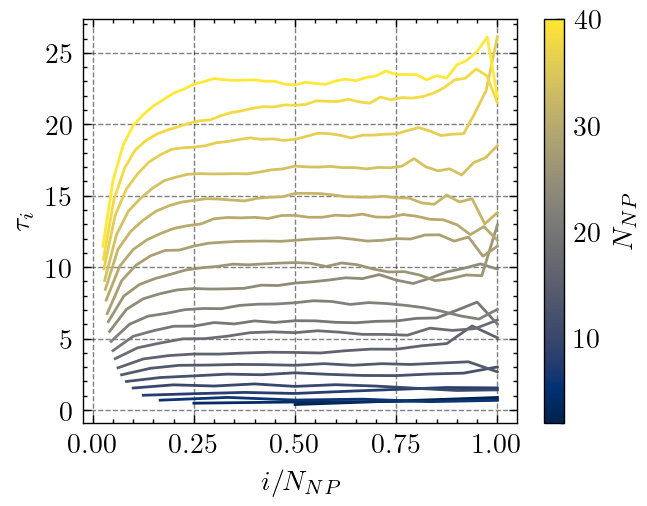

In [519]:
norm = Normalize(vmin=N_vals[0], vmax=N_vals[-1])

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for Np in N_vals:
    ax.plot(np.arange(1,Np+1)/Np, p_vals[Np][:,0], color=cm(norm(Np)))

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

ax.set_ylabel("$\\tau_i$")
ax.set_xlabel("$i/N_{NP}$")

Each plateau value form the "bulk" time constant

Calculate all mode time constants from theory using conductance and capacitance matrix

In [2]:
def calculate_relaxation_times(C_internal, G_full, N_e=2):
    """
    Calculates theoretical relaxation times using conventions where both C and G
    are positive-definite matrices.

    Args:
        C_internal (np.ndarray): The N x N internal capacitance matrix (in aF).
                                 Assumed to be positive-definite.
        G_full (np.ndarray): The (N+2) x (N+2) conductance matrix (in S).
                             Assumed to be positive-definite, with the first 2
                             indices corresponding to electrodes.

    Returns:
        np.ndarray: An array of N positive relaxation time constants (tau)
                    in nanoseconds (ns), sorted from slowest to fastest.
    """
    # Extract the N x N submatrix for internal nodes
    G_mod = G_full[N_e:, N_e:]

    try:
        C_inv = np.linalg.inv(C_internal)
        A = C_inv @ G_mod
        
        eigenvalues = np.linalg.eigvals(A)
        # Eigenvalues should be real and positive with this convention
        real_eigenvalues = np.real(eigenvalues)
        
        # --- THE CORRECTED CALCULATION FOR TAU ---
        # With positive-definite G, the time constant is tau = 1/lambda
        relaxation_times_as = 1.0 / real_eigenvalues
        
        # --- UNIT CONVERSION ---
        # The raw result is in attoseconds (1e-18 s). Convert to nanoseconds (1e-9 s).
        relaxation_times_ns = relaxation_times_as * 1e-9
        
        # Filter out any non-finite values and sort
        finite_times_ns = relaxation_times_ns[np.isfinite(relaxation_times_ns)]
        
        return np.sort(finite_times_ns)[::-1] # Sort descending

    except np.linalg.LinAlgError:
        print("Error: The capacitance matrix C is singular and cannot be inverted.")
        return np.array([])
    except Exception as e:
        print(f"An error occurred: {e}")
        return np.array([])

In [495]:
cond_matrices   = {}
cap_matrices    = {}

for Np in N_vals:
    topo        = {"Nx":Np, "Ny":1, "e_pos":[[0,0],[Np-1,0]], "electrode_type":["constant","constant"]}
    sim_class   = Simulation(topo)
    sim_class.build_conductance_matrix()
    g_mat = sim_class.get_conductance_matrix()
    c_mat = sim_class.get_capacitance_matrix()

    cond_matrices[Np]   = g_mat
    cap_matrices[Np]    = c_mat

In [499]:
taus_theory = {Np : calculate_relaxation_times(cap_matrices[Np],cond_matrices[Np]) for Np in N_vals}
taus_theory[4]

array([0.41759139, 0.19069802, 0.12316637, 0.10280571])

Each mode time constant for different string lengths

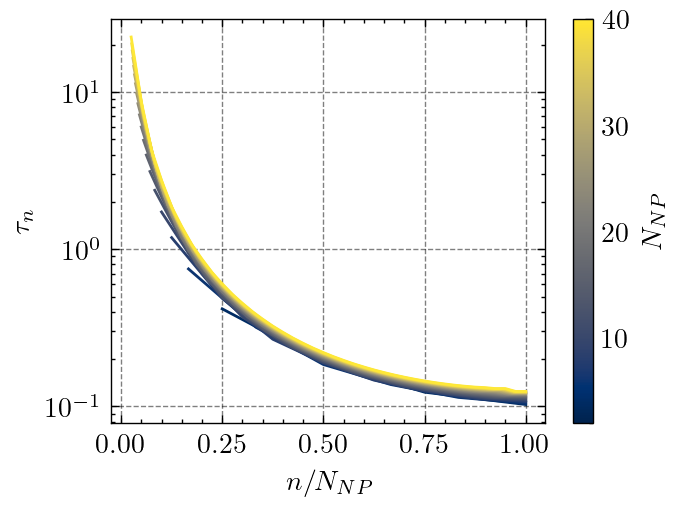

In [509]:
norm = Normalize(vmin=N_vals[0], vmax=N_vals[-1])

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for Np in N_vals:
    ax.plot(np.arange(1,Np+1)/Np, taus_theory[Np], color=cm(norm(Np)))

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

ax.set_ylabel("$\\tau_n$")
ax.set_xlabel("$n/N_{NP}$")
ax.set_yscale('log')

Diffusion and good agreement of theory and simulation

Text(0.5, 1.0, '$T = 293$ K')

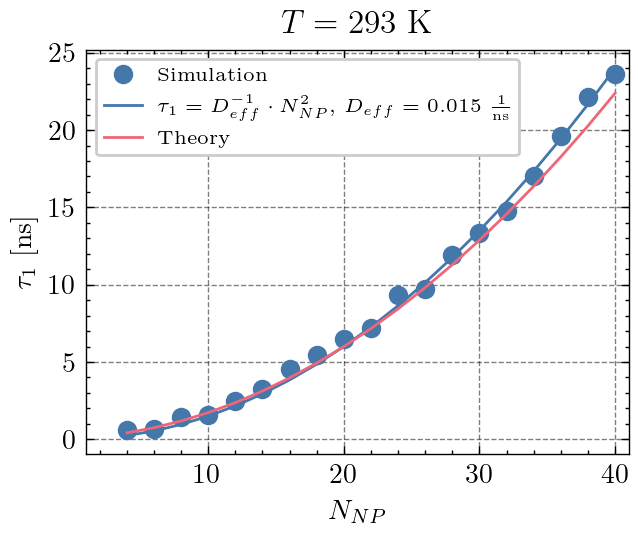

In [505]:
N_range         = np.array(N_vals).copy()[1:]
tau_np          = [np.mean(p_vals[Np][Np//2:-1,0]) for Np in N_range]
tau_np_theory   = [np.max(taus_theory[Np]) for Np in N_range]

def quad_func(x, a):
    return a*x**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p,_ = curve_fit(quad_func, N_range, tau_np)
pp  = ax.plot(N_range, tau_np, 'o', label='Simulation')
ax.plot(N_range, quad_func(np.array(N_range), *p), color=pp[0].get_color(),
        label="$\\tau_1 = D_{eff}^{-1} \cdot N_{NP}^2$, $D_{eff} = "+f"{np.round(p[0],4)}$"+" $\\frac{1}{\\text{ns}}$")
ax.plot(N_range, tau_np_theory, label='Theory')

ax.set_ylabel("$\\tau_1$ [ns]")
ax.set_xlim(1,41)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small', loc='upper left')
ax.set_title(f"$T = 293$ K")

# fig.savefig("../plots/dc_input/linear/closed_circuit_time_scales_vs_N.svg", transparent=True)

# Analysis of Charge Relaxation in a 1D Conductor Chain

*This document summarizes the analysis of charge transport in a 1D chain of `N` conductors, performed on Thursday, August 14, 2025, in Münster. The goal is to understand the system's relaxation dynamics by comparing numerical simulation data with theoretical calculations.*

---

## 1. Theoretical Model

The system is modeled as a coupled RC network. The time evolution of the potentials of the `N` internal nodes, represented by the vector `$\mathbf{V}(t)$`, is described by a system of linear ordinary differential equations.

### 1.1. The Governing Equation & Eigenvalue Problem

The relaxation of the system towards its equilibrium state is governed by the homogeneous equation:

$$
\mathbf{C} \frac{d\mathbf{V}}{dt} = \mathbf{G_{mod}} \mathbf{V}
$$

- `$\mathbf{C}$` is the `N x N` **Capacitance Matrix** for the internal nodes. It is a positive-definite matrix.
- `$\mathbf{G_{mod}}$` is the `N x N` **Internal Conductance Matrix**. In our case, it is a positive-definite matrix (Graph Laplacian convention).
- This can be rewritten as $\frac{d\mathbf{V}}{dt} = \mathbf{A} \mathbf{V}$, where the system matrix is `$\mathbf{A} = \mathbf{C}^{-1} \mathbf{G_{mod}}$`.

### 1.2. Multi-Mode Relaxation & The Slowest Mode (`τ₁`)

The solution to this system is a superposition of `N` exponential decay modes, each corresponding to an eigenvalue `$\lambda_k$` of the system matrix `$\mathbf{A}$`.

$$
\mathbf{V}(t) = \mathbf{V}_{eq} + \sum_{k=1}^{N} c_k \mathbf{v}_k e^{-\lambda_k t}
$$

The relaxation time `$\tau_k$` for each mode is defined as:

$$
\tau_k = \frac{1}{\lambda_k}
$$
*(Note: The positive sign is used because our `$\mathbf{G_{mod}}$` is positive-definite, resulting in positive eigenvalues `$\lambda_k$`)*.

The system has `N` characteristic time constants. The most important one is the slowest mode, **`$\tau_1$`**, which corresponds to the smallest eigenvalue and governs the long-term relaxation of the entire system.

### 1.3. Connection to Diffusion

In the continuous limit, a simple RC ladder network can be described by the 1D Diffusion Equation: `$\frac{\partial V}{\partial t} = D \frac{\partial^2 V}{\partial x^2}$`.

- The solution to this equation predicts that the slowest relaxation time `$\tau_1$` scales with the square of the system's length `L`: `$\tau_1 = \frac{L^2}{\pi^2 D}$`.
- For our discrete system of length `N`, this implies a scaling law: **`$\tau_1 \propto N^2$`**.
- This allows us to define an **effective diffusion constant, `D_eff`**, for our complex system from the slope `m` of a `$\tau_1$` vs. `N²` plot: `$$D_{eff} = \frac{a^2}{\pi^2 m}$$` where `a` is the internode spacing (can be set to 1).

---

## 2. Analysis of Simulation Data

The theoretical predictions were tested against data from a charge transport simulation (e.g., Monte Carlo).

### 2.1. Extracting `τ₁` via Exponential Fitting

For each node `k` in a chain of length `N`, we tracked its potential `V_k(t)`. The slowest time constant `$\tau_1$` was extracted by fitting the "tail" of the relaxation curve to a single exponential function.

- **Fitting Function:** `$$V(t) = V_{eq} - A e^{-t/\tau}$$`
- **Fitting Window:** To isolate the `$\tau_1$` mode, the fit was performed on a data slice `$[t_{start}, t_{stop}]$`, for example, between 90% and 99.5% of the total relaxation towards the equilibrium value `V_eq`.

### 2.2. The "Plateau" Method

To find the single characteristic `$\tau_1$` for a given chain length `N`, the fitted `$\tau_k$` from each node was plotted against its normalized position `k/N`. This plot revealed three distinct regions:
1.  **Transient/Propagation Region:** At small `k/N` (for large `N`), the fitted `$\tau_k$` is artificially low due to signal propagation effects.
2.  **Stable "Bulk" Plateau:** Across the majority of the chain, the fitted `$\tau_k$` values are constant. This plateau value represents the true system-wide `$\tau_1$`.
3.  **Boundary Effect:** Near `k/N = 1`, a small deviation can occur due to the node's connection to the ground electrode.

The definitive `$\tau_1$` from the simulation was determined by averaging the values across the stable plateau region.

---

## 3. Synthesis & Final Conclusion

The final step was to compare the results from the two approaches.

- The `$\tau_1$` values from the **simulation plateaus** were plotted against `N²`.
- The `$\tau_1$` values from the **theoretical eigenvalue calculation** were plotted on the same graph.

**Results:**
1.  **Excellent Agreement:** The theoretical and simulated `$\tau_1$` values show very strong agreement across a wide range of system sizes `N`. This provides a complete end-to-end validation of the physical model, the simulation, and the analysis methods.
2.  **Diffusive Transport Confirmed:** Both methods confirm the `$\tau_1 \propto N^2$` scaling, demonstrating that the macroscopic charge transport in the system is diffusive.
3.  **Final Conclusion:** The system's relaxation is multi-modal, but its long-term behavior is dominated by a single slow mode `$\tau_1$` that scales quadratically with system size. An effective diffusion constant `D_eff` can be extracted from this scaling, providing a single metric to characterize the transport efficiency of the conductor chain architecture.

Complex mode sum fit: Skip for now

In [ ]:
# p_vals, cov_vals = {}, {}
# for Np in N_vals:
#     N, M            = Np + 1, 100
#     p_tmp, cov_tmp  = [], []
#     for k in range(1,N):

#         def func(t, tau, t0, k, N, M):
#             v_inf   = 1.0 - k / N
#             n       = np.arange(1, M + 1)
#             A_th    = (2.0 / np.pi) * (1.0 / n) * np.sin(np.pi * n * (k / float(N)))
#             te      = np.maximum(t - t0, 0.0)
#             E       = np.exp(-(n**2)[:, None] * (te[None, :] / tau))
#             series  = (A_th[:, None] * E).sum(axis=0)
#             return v_inf - series

#         def helper(t, tau, t0):
#             return func(t, tau, t0, k, N, M)

#         i_U0    = np.where(np.array(N_vals)==(Np))[0][0]
#         U_0     = U_0_vals[i_U0]
#         t_test  = t_vals.copy()
#         v_test  = pot[Np][k].values.copy()/U_0
#         p, cov  = curve_fit(helper, t_test, v_test)

#         p_tmp.append(p)
#         cov_tmp.append(cov)

#     p_vals[Np]      = np.array(p_tmp)
#     cov_vals[Np]    = np.array(cov_tmp)

In [ ]:
# M = 100
# p_vals2, cov_vals2 = {}, {}

# for Np in N_vals:
#     N       = Np + 1
#     i_U0    = np.where(np.array(N_vals)==(Np))[0][0]
#     U_0     = U_0_vals[i_U0]

#     p_tmp, cov_tmp  = [], []
#     for k in range(1,N):

#         t_test  = t_vals.copy()
#         v_test  = pot[Np][k].values.copy()/U_0
        
#         v_inf   = 1.0 - k / N
#         n       = np.arange(1, M + 1)
#         A_th    = (2.0 / np.pi) * (1.0 / n) * np.sin(np.pi * n * (k / float(N)))

#         def func(t, tau, t0, alpha, s):
            
#             te      = np.maximum(t - t0, 0.0)
#             E       = np.exp(-(n**alpha)[:, None] * (te[None, :] / max(tau, np.finfo(float).eps)))
#             series  = (A_th[:, None] * E).sum(axis=0)
#             return v_inf - s * series

#         # bounds
#         lb = [np.finfo(float).eps, t_test[0] - (t_test[-1] - t_test[0]), 1.0, 0.5]
#         ub = [1e12, t_test[-1], 2.5, 1.5]
#         p0 = [20, 0, 2.0, 1.0]

#         p, cov = curve_fit(func, t_test, v_test, p0=p0, bounds=(lb,ub))

#         p_tmp.append(p)
#         cov_tmp.append(cov)

#     p_vals2[Np]      = np.array(p_tmp)
#     cov_vals2[Np]    = np.array(cov_tmp)

$$\tau_{\text{slow}}=\frac{R_\text{eff}\,C_{\Sigma}}{\pi^{2}}\,(N+1)^{2}, \qquad R_\text{eff}= \begin{cases} R_{\text{t}}, & \text{(RC regime)} \\[4pt] R_{\text{SE}}(T,V), & \text{(SE regime)} \end{cases}$$

**Why $N^{2}$?** A 1-D RC ladder is formally a diffusion line; the longest spatial wavelength that fits in length $Na$ has $k_{\min}\!=\!\pi/(N+1)a$, so the relaxation time goes like $1/k_{\min}^{2}$.
| quantity | symbol | value you gave | comment |
|----------|--------|---------------|---------|
| total node capacitance | $C_\Sigma$ | $C_0+2C\approx 3\;\mathrm{aF}$ | identical sites |
| charging energy | $E_C=e^{2}/2C_\Sigma\approx 27\;\mathrm{meV}$ | matches aF scale |
|thermal energy | $k_B T$ | 25 meV @ 293 K ⟂ 0.43 meV @ 5 K | CB off vs on |
| bias in your runs | $V_\text{in}$ | 0.10 V (293 K) ⟂ 0.02 V (5 K) | above vs **below** CB threshold $E_C/e≈0.027\;\text{V}$ |

**293 K, 0.10 V** $k_BT\sim E_C$ *and* $eV\gg E_C$ → Coulomb blockade negligible. Use $R_\text{eff}=R_t$.
For $R_t=100\;\text{M}\Omega,\;C_\Sigma=3\;\text{aF},\;N=20$: $\tau_{\text{slow}}\approx$ **13 ns** (numbers in python check). * **5 K, 0.02 V** $k_BT\ll E_C$ and bias is **below threshold** → sequential tunnelling is Arrhenius-suppressed:
$$R_{\text{SE}}\approx R_t\,\exp\!\Bigl[\frac{E_C}{k_BT}\Bigr]\; \bigl(\tfrac{E_C}{e|V|}-1\bigr)^{-1}\;{\Rightarrow}\; R_{\text{SE}}\;\text{in the}\;\mathrm{G}\Omega\text{–}\mathrm{T}\Omega\;\text{range}$$

- $N^2$ dependence as we have **diffusive-limited relaxation** (governed by $R$ and $C$)
- We get about the same prefactor as theory suggests. Deviations due to finite-$N$
- We have a ***hierarchical timescale*** of eigenmodes, i.e. first NPs relax faster and last NP are driven by slowest mode

## DC Input - Voltage Distribution - Open Circuit

In [3]:
def shift_and_append(dfs_dict):
    for name, df in dfs_dict.items():
        col1 = df.pop("1")  # remove column 1
        df.columns = range(df.shape[1])  # reassign column names to keep them sequential
        df[f"{len(df.columns)}"] = col1  # append column 1's data at the end
    return dfs_dict


# Parameter
folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
N_voltages  = 50000
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]

# Potentials
U_0_vals    = [pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Ne=2.csv").loc[0,'E0'] for N_p in N_vals]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Ne=2.csv") for N_p in N_vals}
pot         = shift_and_append(pot)
pot_eq      = pd.DataFrame([pot[N_p].iloc[45000:,:].mean().values / U_0_vals[i] for i, N_p in enumerate(N_vals)],index=N_vals).T.round(2)

# Output Current
out_curr    = {N_p : pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Ne=2.csv")['Observable'].values for N_p in N_vals}

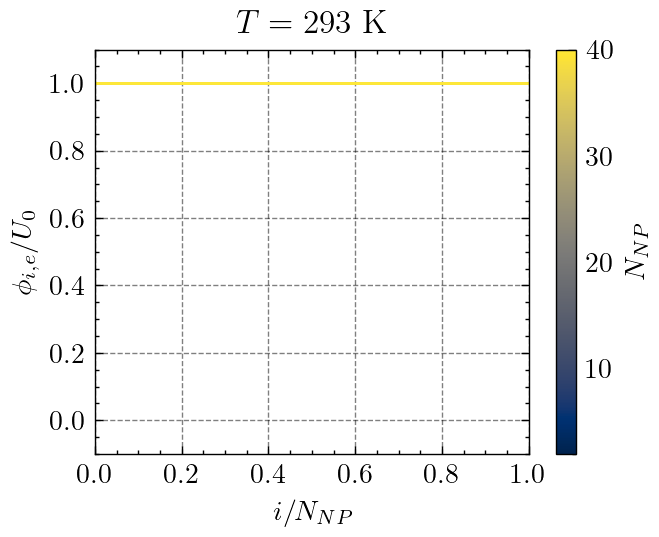

In [4]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_potential.svg", transparent=True)

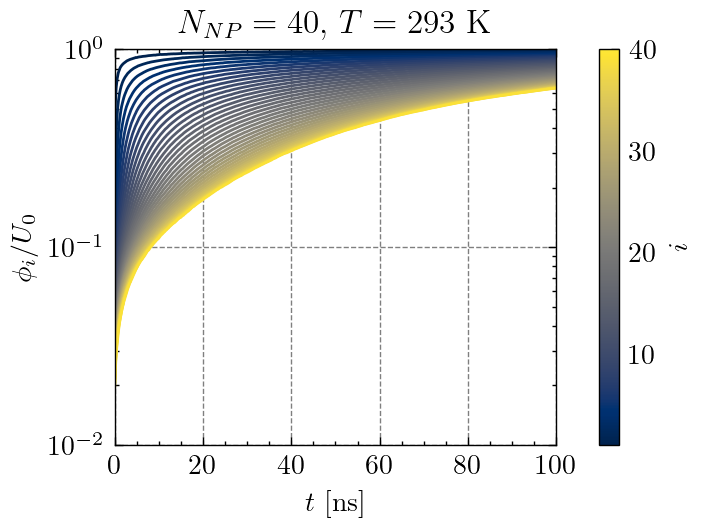

In [5]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
Np      = 40
i_U0    = np.where(np.array(N_vals)==Np)[0][0]
U_0     = U_0_vals[i_U0]
norm    = Normalize(vmin=1, vmax=Np)

for i in range(1,Np):
    ax.plot(t_vals, pot[Np][i].values/U_0, color=cm(norm(i)))

ax.set_title("$N_{NP} = 40$, $T = 293$ K")
ax.set_xlim(0,100)
ax.set_ylim(0.01,1)
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_time_series.svg", transparent=True)

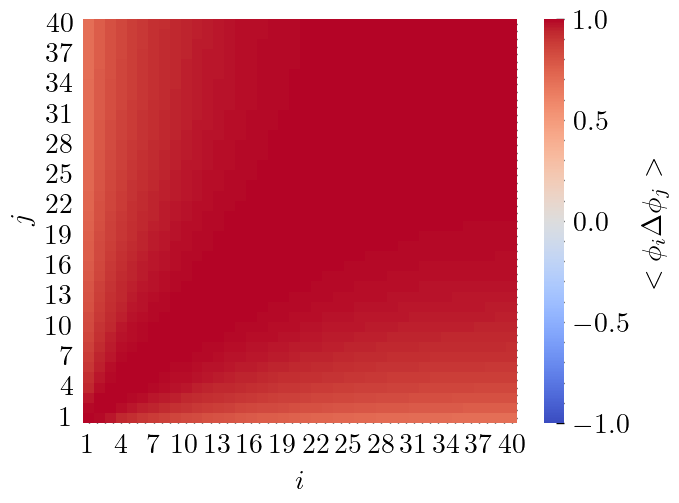

In [5]:
Np  = 40
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(pot[Np].iloc[:,1:-1].corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\phi_{i}\Delta\phi_{j}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$j$")
ax.invert_yaxis()
plt.yticks(rotation=0) 

fig.savefig("../plots/dc_input/linear/open_circuit_node_pot_corr.svg", transparent=True)

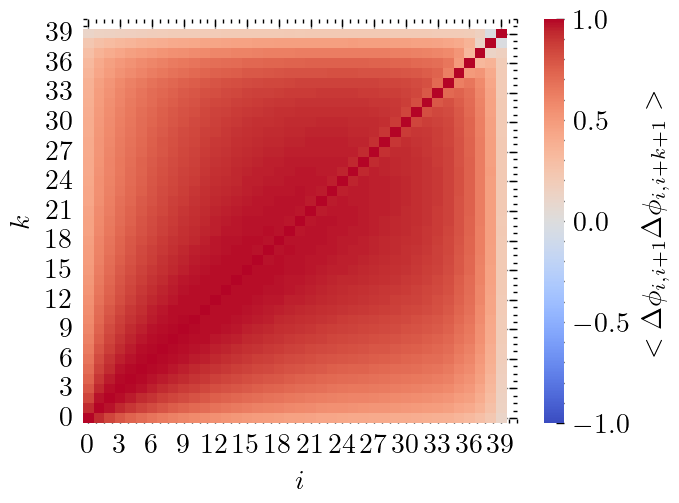

In [6]:
Np      = 40
p_diff  = pot[Np].diff(axis=1).drop(columns=0).values
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")
ax.invert_yaxis()
plt.yticks(rotation=0) 

fig.savefig("../plots/dc_input/linear/open_circuit_node_pot_diff_corr.svg", transparent=True)

- Without a ground path, charges accumulate until the **entire string floats** at $U_0$ --> $\phi_i \approx U_0 \forall i$

In [6]:
p_vals, cov_vals = {}, {}
p0, p1 = 0.9, 0.995
for Np in N_vals:
    p_tmp, cov_tmp = [], []
    for k in range(1,Np+1):

        x       = t_vals.copy()
        y       = pot[Np].loc[:,k].values
        y_max   = np.mean(y[-1000:])
        def func(t, tau, a0):
            return y_max - a0*np.exp(-t/tau)
        
        t0      = np.argmax(y>p0*y_max)
        t1      = np.argmax(y>p1*y_max)
        x_fit   = x.copy()[t0:t1]
        y_fit   = y.copy()[t0:t1]
        p, cov  = curve_fit(func, x_fit, y_fit, p0=[20,y_max], bounds=((0,0),(np.inf,np.inf)))

        p_tmp.append(p)
        cov_tmp.append(cov)
    p_vals[Np] = np.array(p_tmp)
    cov_vals[Np] = np.array(cov_tmp)

Text(0.5, 0, '$i/N_{NP}$')

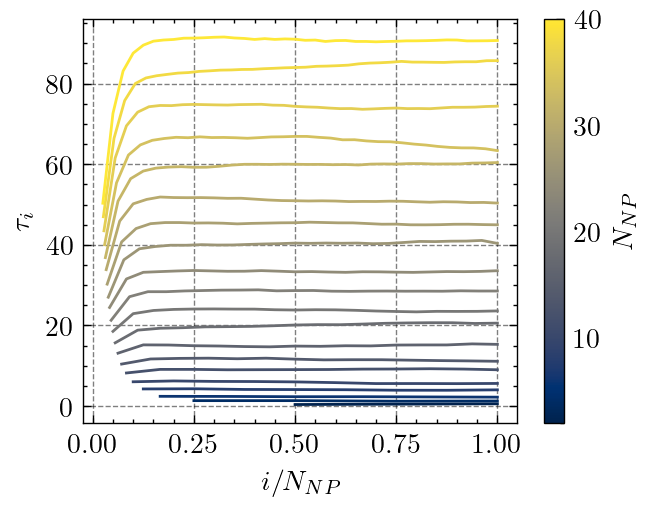

In [7]:
norm = Normalize(vmin=N_vals[0], vmax=N_vals[-1])

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for Np in N_vals:
    ax.plot(np.arange(1,Np+1)/Np, p_vals[Np][:,0], color=cm(norm(Np)))

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

ax.set_ylabel("$\\tau_i$")
ax.set_xlabel("$i/N_{NP}$")

In [8]:
cond_matrices   = {}
cap_matrices    = {}

for Np in N_vals:
    topo        = {"Nx":Np, "Ny":1, "e_pos":[[0,0],[Np-1,0]], "electrode_type":["constant","floating"]}
    sim_class   = Simulation(topo)
    sim_class.build_conductance_matrix()
    g_mat = sim_class.get_conductance_matrix()
    c_mat = sim_class.get_capacitance_matrix()

    cond_matrices[Np]   = g_mat
    cap_matrices[Np]    = c_mat

In [9]:
cond_matrices[2][2:,2:]

array([[ 8.e-08, -4.e-08],
       [-4.e-08,  4.e-08]])

In [10]:
taus_theory = {Np : calculate_relaxation_times(cap_matrices[Np],cond_matrices[Np]) for Np in N_vals}
taus_theory[4]

array([1.10163148, 0.2263651 , 0.12807107, 0.10044111])

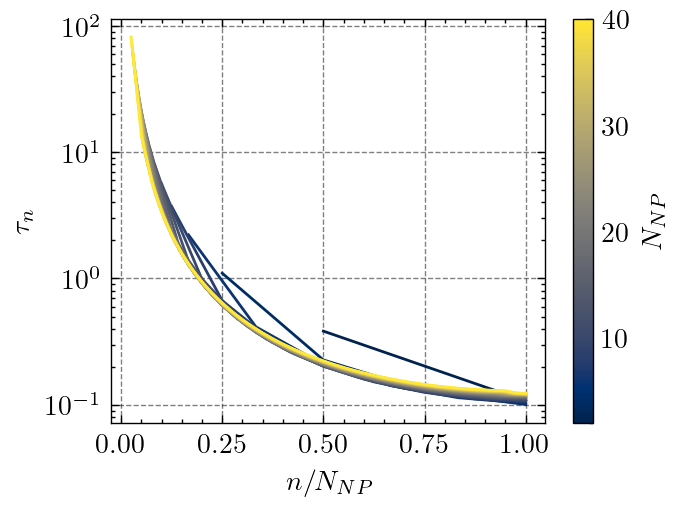

In [11]:
norm = Normalize(vmin=N_vals[0], vmax=N_vals[-1])

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for Np in N_vals:
    ax.plot(np.arange(1,Np+1)/Np, taus_theory[Np], color=cm(norm(Np)))

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

ax.set_ylabel("$\\tau_n$")
ax.set_xlabel("$n/N_{NP}$")
ax.set_yscale('log')

Text(0.5, 1.0, '$T = 293$ K')

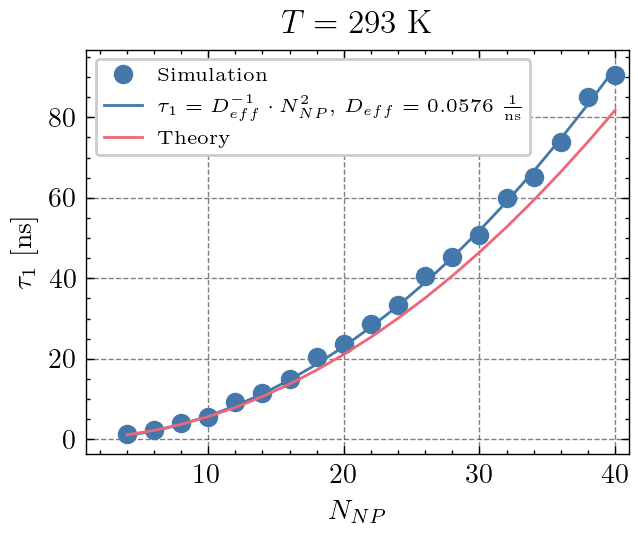

In [12]:
N_range         = np.array(N_vals).copy()[1:]
tau_np          = [np.mean(p_vals[Np][Np//2:-1,0]) for Np in N_range]
tau_np_theory   = [np.max(taus_theory[Np]) for Np in N_range]

def quad_func(x, a):
    return a*x**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p,_ = curve_fit(quad_func, N_range, tau_np)
pp  = ax.plot(N_range, tau_np, 'o', label='Simulation')
ax.plot(N_range, quad_func(np.array(N_range), *p), color=pp[0].get_color(),
        label="$\\tau_1 = D_{eff}^{-1} \cdot N_{NP}^2$, $D_{eff} = "+f"{np.round(p[0],4)}$"+" $\\frac{1}{\\text{ns}}$")
ax.plot(N_range, tau_np_theory, label='Theory')

ax.set_ylabel("$\\tau_1$ [ns]")
ax.set_xlim(1,41)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small', loc='upper left')
ax.set_title(f"$T = 293$ K")

# fig.savefig("../plots/dc_input/linear/open_circuit_time_scales_vs_N.svg", transparent=True)